# FaceForensics++: Learning to Detect Manipulated Facial Images
##### Inspired from : https://arxiv.org/abs/1901.08971v1

## Problem Definition:
#####  As there is a lot of active research going on image/video generation and manipulation, that helps to evolve many new ways to manipulate the original sources at the same time this leads to a loss of trust in digital content, but it might even cause further harm by spreading false information and the creation of fake news. 

#### Have look at this video, seems very realistic but it is actually manipulated 

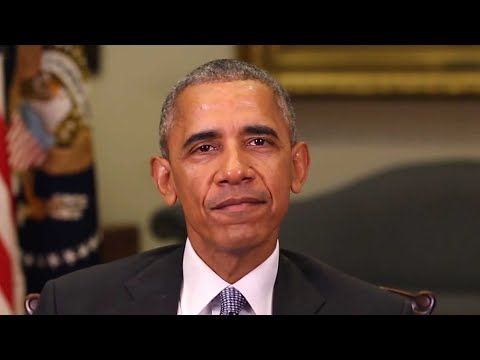

In [59]:
from IPython.display import YouTubeVideo
YouTubeVideo('cQ54GDm1eL0') #Reference:https://www.youtube.com/watch?v=cQ54GDm1eL0

#### NOTE: The video I have included here, is not to offend anyone. This is just an example how digital content is losing the trust and just to address the problem for this case study    

## Objective

#### We need to build a model such that it should recognize whether the given video(or  image sequence) is  fake or real. 

## Data Background

#### The Faceforensics++ data was collected by Visual Computing Group (http://niessnerlab.org/) , one can obtain this data on accepting their terms and conditions. To download and extract the data please visit https://github.com/ondyari/FaceForensics

#### Brief summery about Data Acquisition by Faceforensics++
1. Total 1000 videos (videos are like news readers reading news) are downloaded from youtube.
2. Manipulated vidoes are generated by using 3 automated state-of-the-art face manipulation methods (viz., DeepFakes, FaceSwap, Face2Face) that are applied to these 1,000  pristine videos.
3. Gathering the images from both pritine videos(real) and manipulated videos(fake)

To get more understanding please visit https://arxiv.org/pdf/1901.08971v1.pdf 

## Data Gathering

#### 1. I have downloaded total of 100 raw videos (50 original+50 manipulated) on accepting terms and conditions mentioned in FaceForensics++ github page
#### 2. For each video each folder is created with the same name and placed the extracted images in these repective folders 

### To get the total guidence for downloading and extracting data please reach out   https://github.com/ondyari/FaceForensics 


##  The idea of  forgery detection pipeline 

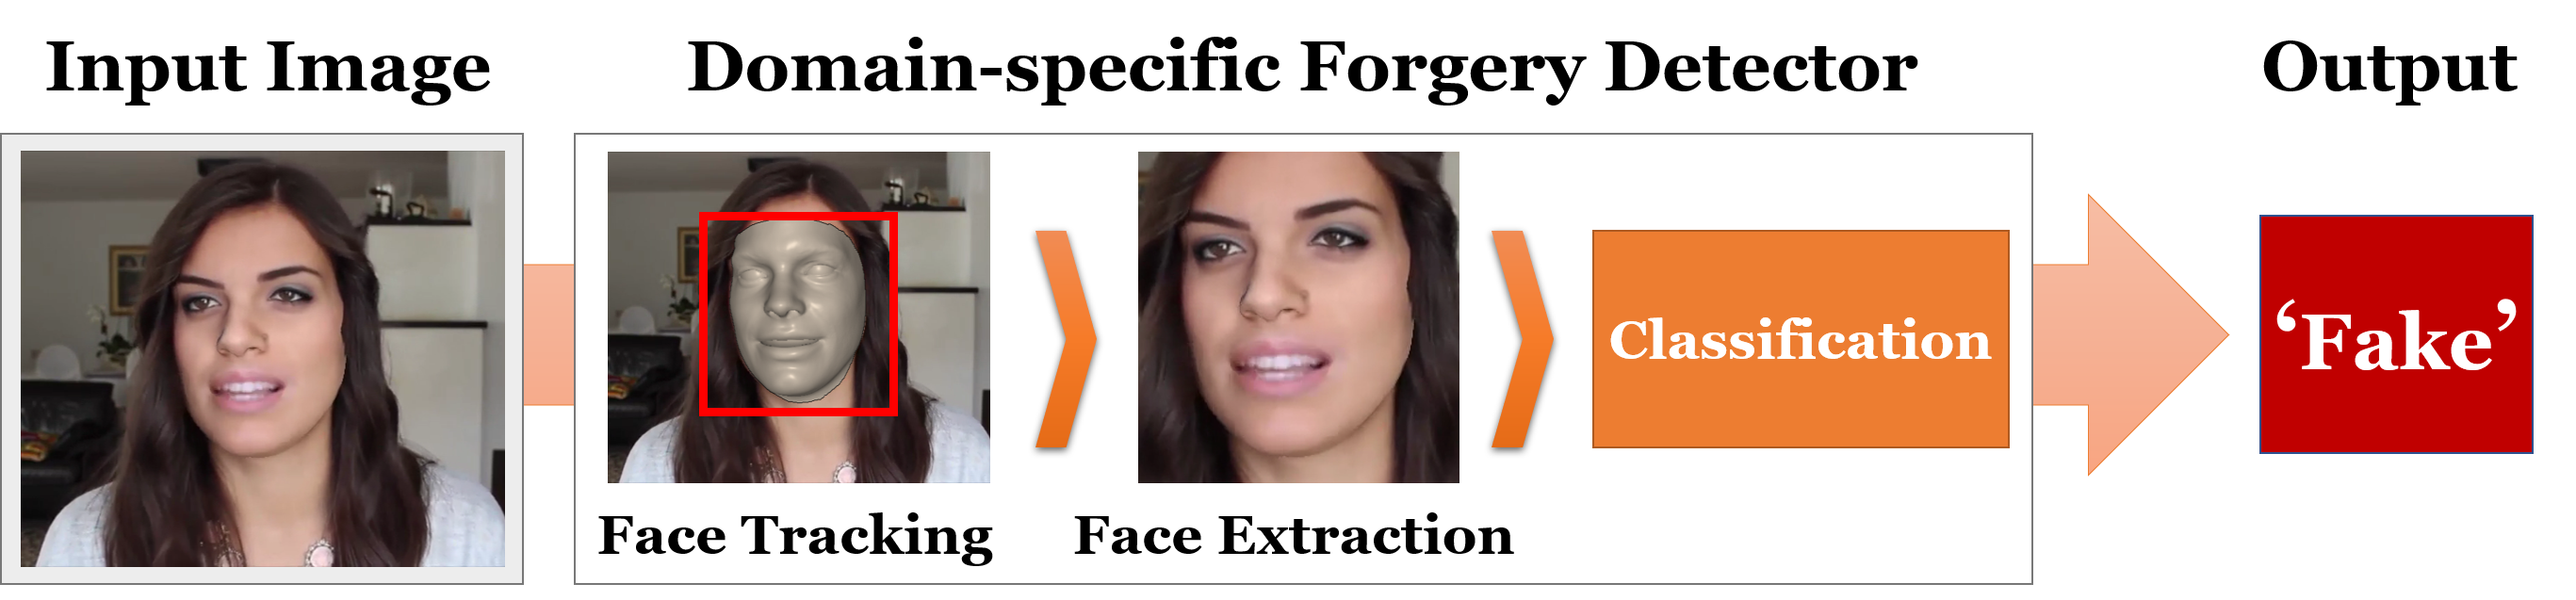

In [60]:
import matplotlib.pyplot as plt #plotting library
import os #OS module to do os level operation such as mkdir,listsdir,..
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np # To handle matrix operations
import cv2 # computer vision library
import dlib # Automatic face tracking library
face_detector = dlib.get_frontal_face_detector() # instantiating face detector class from dlib library 
import joblib # To presist the intermideate files 
import warnings#
warnings.filterwarnings('ignore')# To ignore the unwanted warning messages
from facenet_pytorch import MTCNN
import cv2
from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import glob
from tqdm.notebook import tqdm
import glob
from tqdm.notebook import tqdm
import pandas as pd
from numpy.random import seed
seed(101)
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras import optimizers
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp
%matplotlib inline

In [61]:
DATASET_PATHS = {
    'original': 'C:\\Users\\Dio Gado\\Asmaa\\Data\\original_sequences\\youtube',
    'Deepfakes': 'C:\\Users\\Dio Gado\\Asmaa\\Data\\manipulated_sequences\\Deepfakes'
}

In [62]:
import re 
!pip install str


In [63]:
import tensorflow as tf
tf.device('GPU:0')

### Lets observe extracted images form each type

In [64]:
def read_images(path):
    data = []
    filenames = glob.glob(DATASET_PATHS[path]+'\\c40\\images\\Cropped_faces\\*.jpg')
    #pbar = tqdm(filenames)
    #df = pd.DataFrame()
    for image in filenames:
        id = image.split("_")[2]
        id = re.findall(r'\d+',id)[0]
        og_name = image.split("\\")[-1]
        if path == 'original':
            label = 0
            data.append([id, label,og_name])
        else: 
            label = 1
            data.append([id, label,og_name])
    return data


In [65]:

DATASET_PATHS = {
    'original': 'C:\\Users\\Dio Gado\\Asmaa\\Data\\original_sequences\\youtube',
    'Deepfakes': 'C:\\Users\\Dio Gado\\Asmaa\\Data\\manipulated_sequences\\Deepfakes'
}

In [66]:
data_real = pd.DataFrame(read_images('original'),columns=["id","label","og_id"])
data_Deepfakes = pd.DataFrame(read_images('Deepfakes'),columns=["id","label","og_id"])


In [67]:
frames = [data_real, data_Deepfakes]
df_data = shuffle(pd.concat(frames))

In [68]:
import matplotlib.pylab as plt


(array([     0.,      0.,      0.,      0.,      0., 126232.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

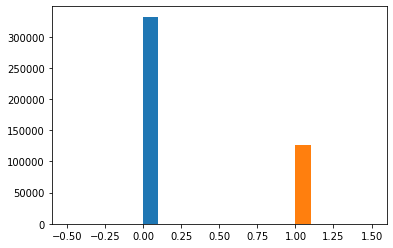

In [69]:
class_2 = np.ones(df_data['label'].value_counts()[0])
class_1 = np.zeros(df_data['label'].value_counts()[1])
plt.hist(class_1)
plt.hist(class_2)




In [70]:
df_data.head()

,id,label,og_id
318982,0792338336,1,0792338336_cropped.jpg
11643,0017956958,1,0017956958_cropped.jpg
100730,04550506,0,04550506_cropped.jpg
36609,0056930763,1,0056930763_cropped_2.jpg
44930,0070389480,1,0070389480_cropped.jpg


In [71]:
df_0 = df_data[df_data['label'] == 0].sample(30000, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(30000, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    30000
0    30000
Name: label, dtype: int64

In [72]:
y = df_data['label']


In [73]:
df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=101, stratify=y)


In [74]:
base_dir = 'C:\\Users\\Dio Gado\\Asmaa\\Data\\base_dir\\'
train_dir = os.path.join(base_dir, 'train_dir')

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')


In [75]:
df_data.set_index('id', inplace=False)


,label,og_id
id,,
0375937888,1,0375937888_cropped.jpg
0143106198,1,0143106198_cropped.jpg
01500024,0,01500024_cropped.jpg
04800639,0,04800639_cropped.jpg
0320776676,1,0320776676_cropped.jpg
...,...,...
0262915895,1,0262915895_cropped.jpg
04900125,0,04900125_cropped.jpg
0239414385,1,0239414385_cropped.jpg


In [76]:
train_list = list(df_train['og_id'])
val_list = list(df_val['og_id'])

In [77]:
len(train_list) 

48000

In [78]:
from joblib import Parallel, delayed
import shutil



In [79]:
from subprocess import call
os.listdir('base_dir/train_dir')



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'base_dir/train_dir'

In [50]:
original_youtube_os = os.path.join(train_dir, 'original_youtube')
#os.mkdir(original_youtube_os)
deepfake_os = os.path.join(train_dir, 'deepfake')
#os.mkdir(deepfake_os)


# create new folders inside val_dir
original_youtube_os = os.path.join(val_dir, 'original_youtube')
#os.mkdir(original_youtube_os)
deepfake_os = os.path.join(val_dir, 'deepfake')
os.mkdir(deepfake_os)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Dio Gado\\Asmaa\\Data\\base_dir\\val_dir\\deepfake'

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'base_dir/train_dir'

In [115]:
import pyfastcopy
from subprocess import call


IndentationError: unexpected indent (<ipython-input-115-d2f9e283f670>, line 2)

In [176]:
def build_train_datset(image):

        #count += 1
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
# get the label for a certain image
    target = df_data.loc[df_data['og_id'] == fname]['label']
    if target.any() == 0:
        src = os.path.join("C:\\Users\\Dio Gado\\Asmaa\\Data\\original_sequences\\youtube\\c40\\images\\Cropped_faces\\", fname)
        label = 'original_youtube'
    else:
        src = os.path.join("C:\\Users\\Dio Gado\\Asmaa\\Data\\manipulated_sequences\\Deepfakes\\c40\\images\\Cropped_faces\\",fname)
        label = 'deepfake'
# destination path to image
    dst = os.path.join(train_dir, label,fname)
# copy the image from the source to the destination
    shutil.copyfile(src, dst) 
#pbar = tqdm(train_list)       
#Parallel(n_jobs=6)(delayed(build_train_datset)(t) for t in pbar)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [190]:
def build_test_datset(image):

        #count += 1
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
# get the label for a certain image
    target = df_data.loc[df_data['og_id'] == fname]['label']
    if target.any() == 0:
        src = os.path.join("C:\\Users\\Dio Gado\\Asmaa\\Data\\original_sequences\\youtube\\c40\\images\\Cropped_faces\\", fname)
        label = 'original_youtube'
    else:
        src = os.path.join("C:\\Users\\Dio Gado\\Asmaa\\Data\\manipulated_sequences\\Deepfakes\\c40\\images\\Cropped_faces\\",fname)
        label = 'deepfake'
# destination path to image
    dst = os.path.join(val_dir,label, fname)
# copy the image from the source to the destination
    shutil.copyfile(src, dst) 
#pbar = tqdm(val_list)       
#Parallel(n_jobs=6)(delayed(build_test_datset)(t) for t in pbar)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [56]:
train_path = 'C:\\Users\\Dio Gado\\Asmaa\\Data\\base_dir\\train_dir\\'
valid_path = 'C:\\Users\\Dio Gado\\Asmaa\\Data\\base_dir\\val_dir\\'


In [53]:
from tensorflow.keras.applications import Xception
tensorflow.device("GPU:0")

In [87]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 35
val_batch_size = 35
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [58]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(299,299),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(299,299),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 48000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import Xception




In [39]:
model=Xception(include_top=False,
                 weights='imagenet',
                 input_shape=(299,299,3),pooling ='avg',
                 )
model.summary()


act[0][0]        
__________________________________________________________________________________________________
block5_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 19, 19, 728)  0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 19, 19, 728)  0           block5_sepconv2_bn[0][0]  

In [81]:
base_model = Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,pooling ='avg')  # Do not include the ImageNet classifier at the top.

In [82]:
from tensorflow.keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
from tensorflow.keras import layers,Model



In [83]:
base_model.output

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 2048) dtype=float32>

In [84]:
inputs = Input(shape=(299, 299, 3))

from tensorflow.keras.optimizers import Adam
import tensorflow


In [88]:
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
predicted = Dense(2,activation ='softmax')(x)
model_pretrain = Model(base_model.input, predicted)
model_pretrain.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
          optimizer=Adam(lr = 0.0002),
          metrics=['accuracy'])
pretraining_Xception =model_pretrain.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1)


Epoch 1/20
1372/1372 [==============================] - 242s 177ms/step - loss: 0.1596 - accuracy: 0.9288 - val_loss: 0.1441 - val_accuracy: 0.9271
Epoch 2/20
1372/1372 [==============================] - 248s 181ms/step - loss: 0.1382 - accuracy: 0.9392 - val_loss: 0.1417 - val_accuracy: 0.9306
Epoch 3/20
1372/1372 [==============================] - 247s 180ms/step - loss: 0.1336 - accuracy: 0.9407 - val_loss: 0.1708 - val_accuracy: 0.9213
Epoch 4/20
1372/1372 [==============================] - 247s 180ms/step - loss: 0.1203 - accuracy: 0.9467 - val_loss: 0.1777 - val_accuracy: 0.9175
Epoch 5/20
1372/1372 [==============================] - 248s 181ms/step - loss: 0.1115 - accuracy: 0.9492 - val_loss: 0.4119 - val_accuracy: 0.8615
Epoch 6/20
1372/1372 [==============================] - 247s 180ms/step - loss: 0.1030 - accuracy: 0.9580 - val_loss: 0.1301 - val_accuracy: 0.9446
Epoch 7/20
1372/1372 [==============================] - 250s 182ms/step - loss: 0.0981 - accuracy: 0.9589 - val_

In [91]:
model_pretrain.save("model_finetuned_xception.hdf5")

In [92]:
import seaborn as sns
sns.set()

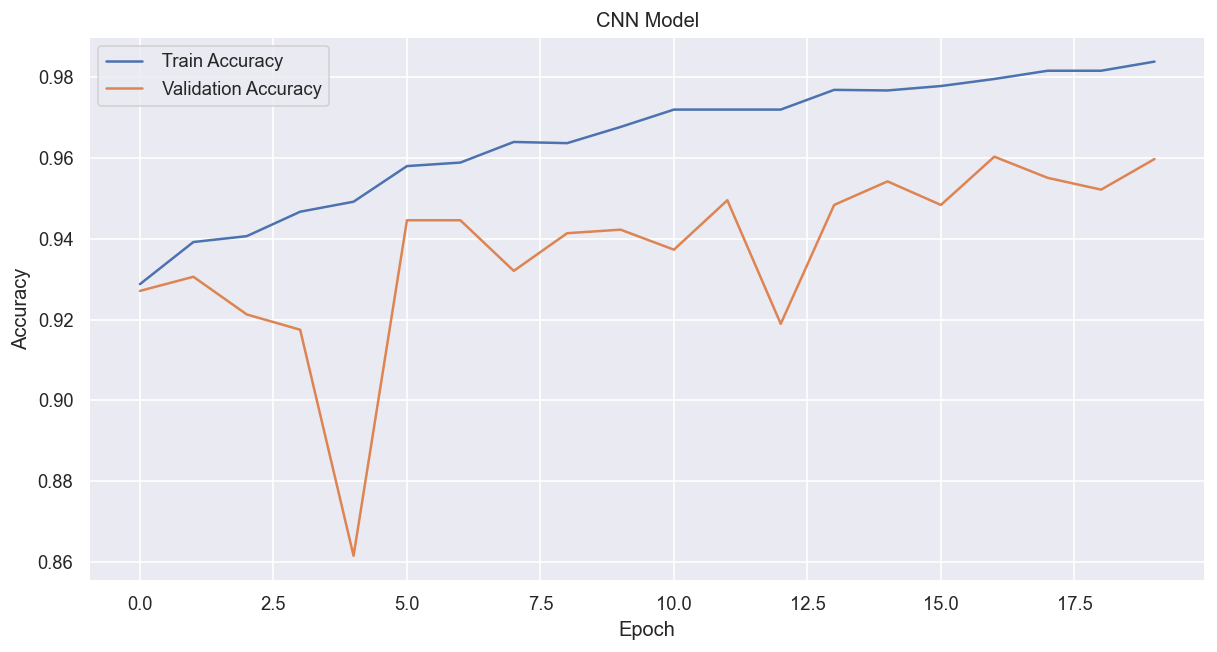

In [94]:

plt.figure(figsize=(12,6),dpi=120)
plt.plot(pretraining_Xception.history['accuracy'], label=' Train Accuracy')
plt.plot(pretraining_Xception.history['val_accuracy'],label=' Validation Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("CNN Model")
plt.legend()
plt.show()

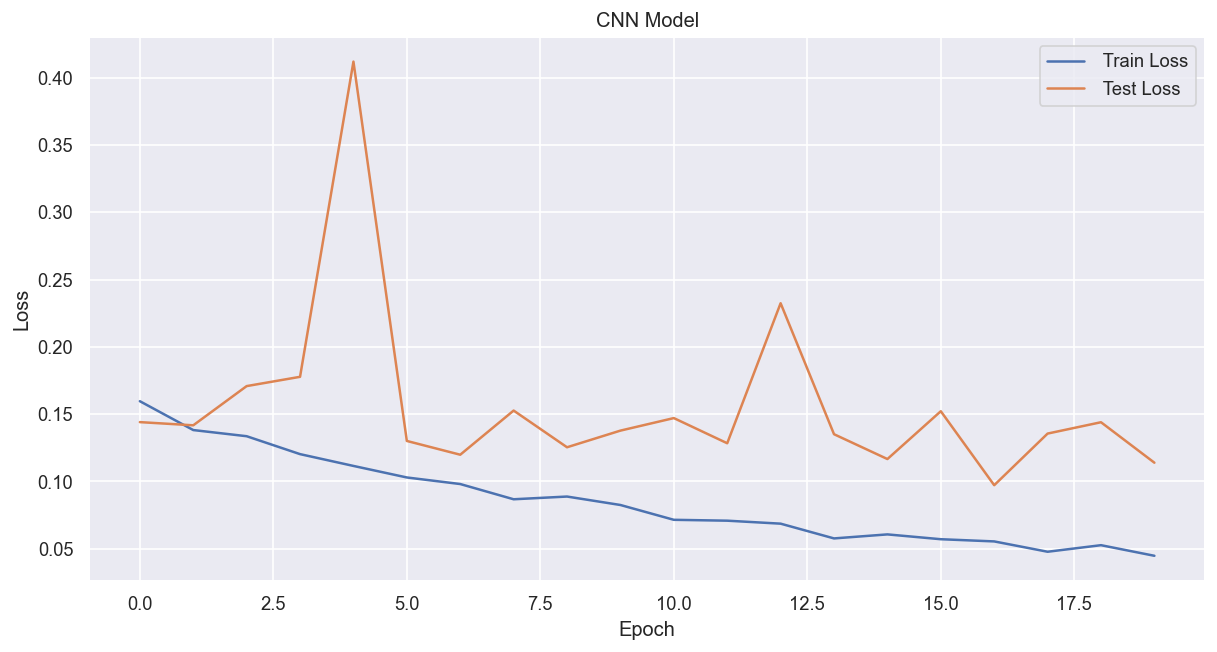

In [96]:
plt.figure(figsize=(12,6),dpi=120)
plt.plot(pretraining_Xception.history['loss'], label=' Train Loss')
plt.plot(pretraining_Xception.history['val_loss'],label=' Test Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("CNN Model")
plt.legend()
plt.show()

In [ ]:
pretraining_Xception.evaluate(,Y_train)

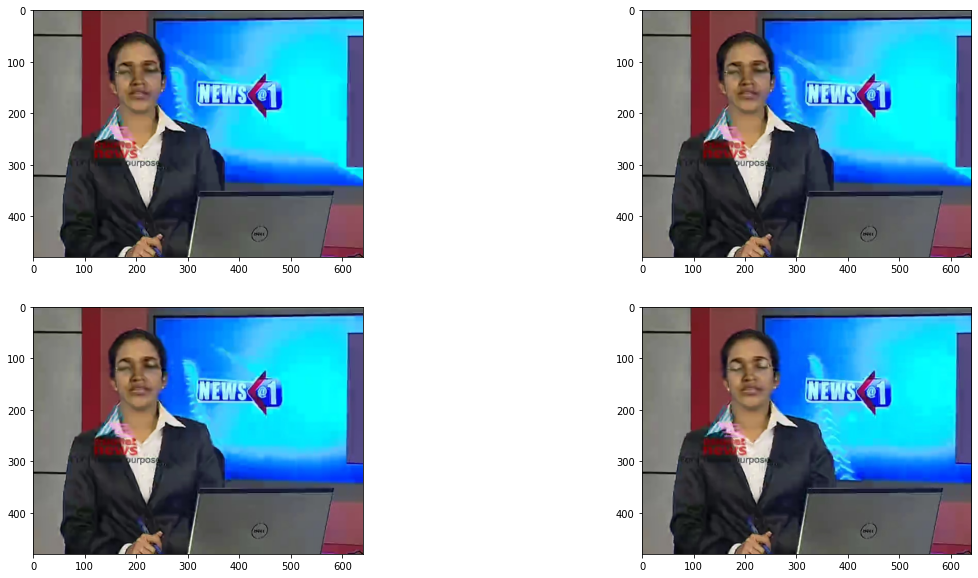

In [118]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(221+i)
    plt.imshow(images[i])